In [32]:
#Load Model and Get Data
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

model = joblib.load(r"F:\subscription-churn-system\models\xgboost_churn.pkl")

valid = pd.read_csv(r"F:\subscription-churn-system\data\processed\valid_features.csv")

X_valid = valid.drop("churn_30d", axis=1)
y_valid = valid["churn_30d"]

valid["churn_probability"] = model.predict_proba(X_valid)[:, 1]

In [33]:
pip install --upgrade pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [34]:
#Global Importance #1 — XGBoost Gain Importance
importances = model.get_booster().get_score(importance_type="gain")

gain_importance = (
    pd.DataFrame(importances.items(), columns=["feature", "gain"])
      .sort_values("gain", ascending=False)
)

gain_importance.head(10)

AttributeError: 'Index' object has no attribute '_format_flat'

                               feature       gain
5                      usage_trend_30d  39.976192
6                  support_tickets_90d  30.251587
7                     payment_failures  19.485104
15         InternetService_Fiber optic  15.317778
19    OnlineBackup_No internet service  13.861654
26                   Contract_Two year  11.132832
25                   Contract_One year   8.748655
29      PaymentMethod_Electronic check   8.442414
16                  InternetService_No   7.779806
17  OnlineSecurity_No internet service   7.696913

In [35]:
# Force new column names to ensure index is clean
gain_importance.columns = ["feature", "gain"]
print(gain_importance.head(10))

                               feature       gain
5                      usage_trend_30d  39.976192
6                  support_tickets_90d  30.251587
7                     payment_failures  19.485104
15         InternetService_Fiber optic  15.317778
19    OnlineBackup_No internet service  13.861654
26                   Contract_Two year  11.132832
25                   Contract_One year   8.748655
29      PaymentMethod_Electronic check   8.442414
16                  InternetService_No   7.779806
17  OnlineSecurity_No internet service   7.696913


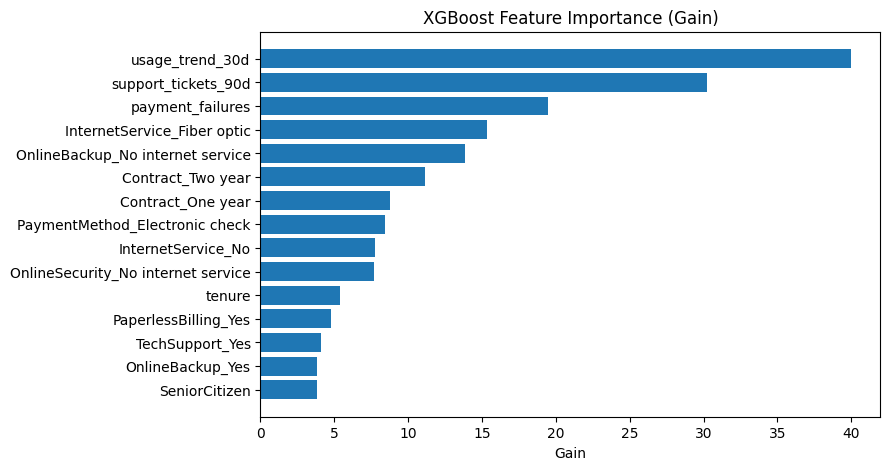

In [36]:
plt.figure(figsize=(8,5))
plt.barh(
    gain_importance["feature"].head(15)[::-1],
    gain_importance["gain"].head(15)[::-1]
)
plt.title("XGBoost Feature Importance (Gain)")
plt.xlabel("Gain")
plt.show()

In [38]:
#Directionality Analysis (Does Feature ↑ Increase Churn?)
def monotonic_analysis(df, feature, bins=10):
    temp = df[[feature, "churn_probability"]].copy()
    temp["bin"] = pd.qcut(temp[feature], bins, duplicates="drop")
    return (
        temp.groupby("bin")["churn_probability"]
        .mean()
        .reset_index()
    )

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16096\3692605094.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp.groupby("bin")["churn_probability"]


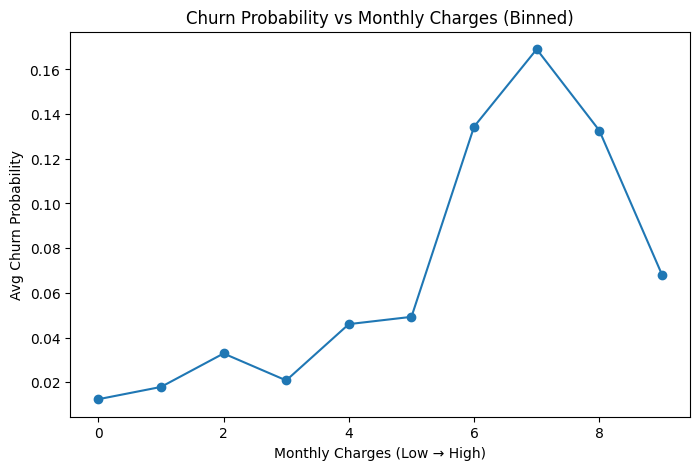

In [39]:
mc_trend = monotonic_analysis(valid, "MonthlyCharges")

plt.figure(figsize=(8,5))
plt.plot(
    mc_trend.index,
    mc_trend["churn_probability"],
    marker="o"
)
plt.title("Churn Probability vs Monthly Charges (Binned)")
plt.xlabel("Monthly Charges (Low → High)")
plt.ylabel("Avg Churn Probability")
plt.show()


In [40]:
#User-Level Explanation (Counterfactual Method)
user_idx = valid.sort_values(
    "churn_probability", ascending=False
).index[0]

user = X_valid.loc[user_idx]
base_prob = valid.loc[user_idx, "churn_probability"]


In [43]:
valid["monthly_revenue"] = valid["MonthlyCharges"]
valid["remaining_lifetime_months"] = 12

valid["revenue_at_risk"] = (
    valid["churn_probability"] *
    valid["monthly_revenue"] *
    valid["remaining_lifetime_months"]
)


In [44]:
summary = pd.DataFrame({
    "Metric": [
        "Average Churn Probability",
        "Total Revenue at Risk",
        "Top 10% Revenue Risk"
    ],
    "Value": [
        valid["churn_probability"].mean(),
        valid["revenue_at_risk"].sum(),
        valid.sort_values("revenue_at_risk", ascending=False)
             .head(int(len(valid)*0.1))["revenue_at_risk"].sum()
    ]
})

summary

AttributeError: 'Index' object has no attribute '_format_flat'

                      Metric          Value
0  Average Churn Probability       0.068390
1      Total Revenue at Risk  109129.675480
2       Top 10% Revenue Risk   97558.906652